In [1]:
import matplotlib.pyplot as plt
import numpy as np

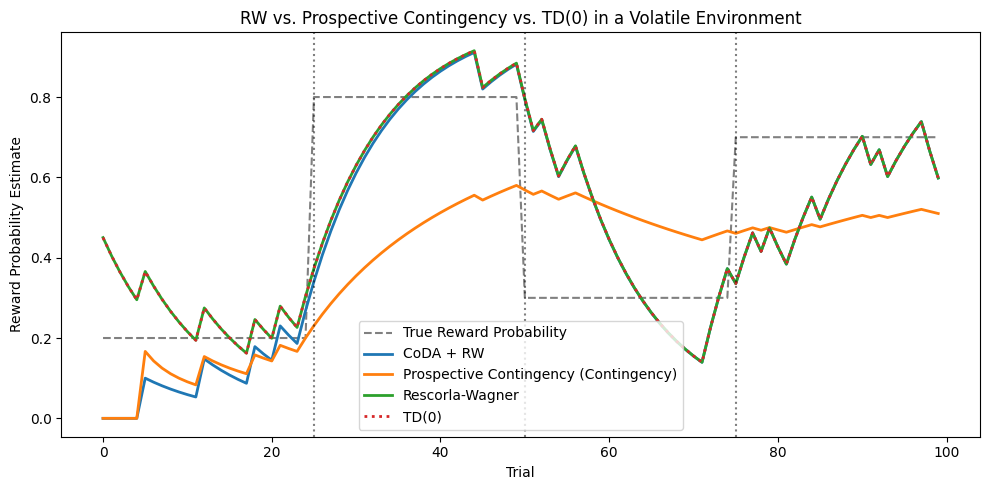

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_trials = 100
switch_points = [0, 25, 50, 75]
reward_probs = [0.2, 0.8, 0.3, 0.7]

# Build reward probability schedule
reward_schedule = np.zeros(n_trials)
for i in range(len(switch_points)):
    start = switch_points[i]
    end = switch_points[i + 1] if i + 1 < len(switch_points) else n_trials
    reward_schedule[start:end] = reward_probs[i]

# Simulate rewards
rewards = np.random.binomial(1, reward_schedule)

# Prospective contingency (rolling average)
window = 10
prospective = []
for t in range(n_trials):
    start = max(0, t - window + 1)
    recent_rewards = rewards[start:t + 1]
    prospective.append(np.mean(recent_rewards) if len(recent_rewards) > 0 else 0.5)



# CoDA simulation
# 
window = 10
prospective = []
values = []
threshold = 0.3 #0.05

alpha_cd = 0.1
V_cd = 0.5

cd_estimates = []
new_index = 0
previous_contingency = 0.5
for t in range(n_trials):

    # Using RW as value proxy

    reward = rewards[t]
    V_cd += alpha_cd * (reward - V_cd)
    cd_estimates.append(V_cd)

    # Using Contingency as contingency proxy
    value = np.mean(rewards[new_index:t + 1])
    values.append(value)


    # Tracking Forward Contingency for splitting clone states
    start = max(0, t - window + 1)
    recent_rewards = rewards[start:t + 1]
    current_contingency = np.mean(recent_rewards) if len(recent_rewards) > 0 else 0.5
    if abs(current_contingency - previous_contingency) > threshold:
        # split a new clone state
        new_index = t
        V_cd = current_contingency

    
    previous_contingency = current_contingency
    prospective.append(V_cd)

# Rescorla-Wagner simulation
alpha_rw = 0.1
V_rw = 0.5
rw_estimates = []
for reward in rewards:
    V_rw += alpha_rw * (reward - V_rw)
    rw_estimates.append(V_rw)

# TD(0) simulation
alpha_td = 0.1
V_td = 0.5
td_estimates = []
for reward in rewards:
    V_td += alpha_td * (reward - V_td)
    td_estimates.append(V_td)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(reward_schedule, label="True Reward Probability", linestyle='--', color='gray')
plt.plot(prospective, label="CoDA + RW", lw=2)
plt.plot(values, label="Prospective Contingency (Contingency)", lw=2)
plt.plot(rw_estimates, label="Rescorla-Wagner", lw=2)
plt.plot(td_estimates, label="TD(0)", lw=2, linestyle=':')
for sp in switch_points[1:]:
    plt.axvline(sp, linestyle=':', color='black', alpha=0.5)
plt.xlabel("Trial")
plt.ylabel("Reward Probability Estimate")
plt.title("RW vs. Prospective Contingency vs. TD(0) in a Volatile Environment")
plt.legend()
plt.tight_layout()
plt.show()


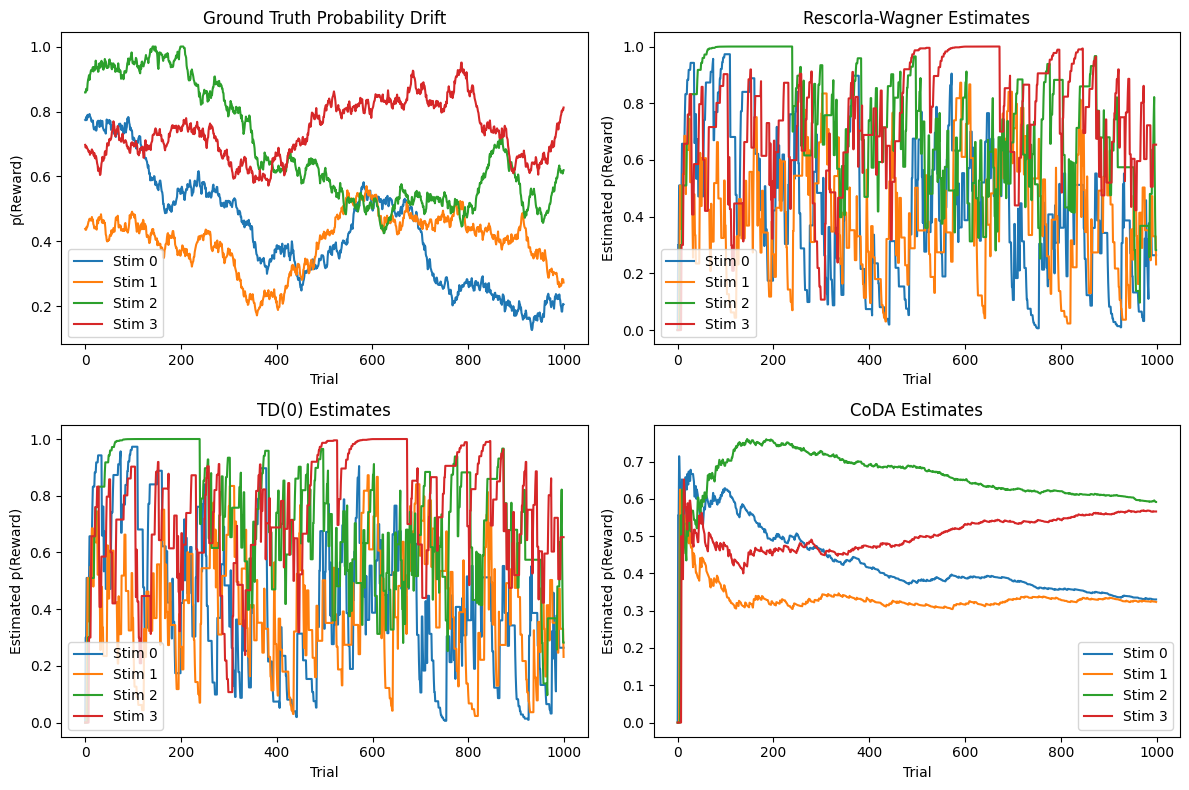

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1) Drifting Multi-Stimulus Environment
# -----------------------------------------------------------------
class DriftingMultiStimulusEnvironment:
    """
    On each trial, randomly selects one of n_stimuli,
    Bernoulli reward with prob p[i], then p[i] drifts slightly.
    """
    def __init__(self, n_stimuli, drift_scale=0.01, seed=None):
        """
        Args:
            n_stimuli (int): number of stimuli/arms.
            drift_scale (float): Std dev of Gaussian drift applied each step to each arm's p.
            seed (int): Optional random seed for reproducibility.
        """
        self.n_stimuli = n_stimuli
        self.drift_scale = drift_scale
        self.rng = np.random.default_rng(seed)

        # Initialize each arm's probability in [0,1]
        self.reward_probs = self.rng.random(n_stimuli)

    def step(self):
        """
        1) Randomly pick a stimulus i in [0, n_stimuli).
        2) Reward ~ Bernoulli(p[i]).
        3) Drift each p[i] by N(0, drift_scale), then clip to [0,1].
        Returns:
            (stimulus_idx, reward)
        """
        # 1) random stimulus
        stim_idx = self.rng.integers(0, self.n_stimuli)

        # 2) reward sample
        p = self.reward_probs[stim_idx]
        reward = 1 if self.rng.random() < p else 0

        # 3) drift each arm
        drift = self.rng.normal(0, self.drift_scale, size=self.n_stimuli)
        self.reward_probs += drift
        np.clip(self.reward_probs, 0, 1, out=self.reward_probs)

        return stim_idx, reward

# -----------------------------------------------------------------
# 2) Rescorla-Wagner for Multiple Stimuli
# -----------------------------------------------------------------
class RescorlaWagnerMulti:
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.V = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        error = reward - self.V[stimulus_idx]
        self.V[stimulus_idx] += self.alpha * error


# -----------------------------------------------------------------
# 3) TD(0) for Multiple Stimuli
# -----------------------------------------------------------------
class TDMulti:
    def __init__(self, n_stimuli, alpha=0.3, init_value=0.0):
        self.n_stimuli = n_stimuli
        self.alpha = alpha
        self.Q = np.full(n_stimuli, init_value, dtype=float)

    def update(self, stimulus_idx, reward):
        td_error = reward - self.Q[stimulus_idx]
        self.Q[stimulus_idx] += self.alpha * td_error


# -----------------------------------------------------------------
# 4) CoDAMulti Class
# -----------------------------------------------------------------
class CoDAMulti:
    """
    A simple version of a "Contingency-dependent" learner that tracks:
      - A[i]: count(stimulus i, reward=1)
      - B[i]: count(stimulus i, reward=0)
      - C[i]: count(no stimulus i, reward=1)
    Then computes V[i] = F_beta(specificity_i, sensitivity_i).
    """
    def __init__(self, n_stimuli, beta=1.0, init_value=0.0):
        self.n_stimuli = n_stimuli
        self.beta = beta
        # Counters
        self.A = np.full(n_stimuli, init_value, dtype=float)  # Stimulus & reward
        self.B = np.full(n_stimuli, init_value, dtype=float)  # Stimulus & no reward
        self.C = np.full(n_stimuli, init_value, dtype=float)  # No stimulus & reward
        self.V = np.full(n_stimuli, 0.0, dtype=float)

    def get_specificity(self, A_val, B_val):
        denom = A_val + B_val
        return A_val / denom if denom > 0 else 0.0

    def get_sensitivity(self, A_val, C_val):
        denom = A_val + C_val
        return A_val / denom if denom > 0 else 0.0

    def get_Fbeta(self, specificity, sensitivity, beta):
        if specificity == 0 and sensitivity == 0:
            return 0.0
        return (1 + beta**2) * (specificity * sensitivity) / (beta**2 * specificity + sensitivity)

    def update(self, stimulus_idx, reward):
        mask = np.arange(self.n_stimuli) != stimulus_idx

        # Update counts
        if reward == 1:
            self.A[stimulus_idx] += 1
            self.C[mask] += 1
        else:
            self.B[stimulus_idx] += 1

        # Recompute each V[i]
        for i in range(self.n_stimuli):
            spec = self.get_specificity(self.A[i], self.B[i])
            sens = self.get_sensitivity(self.A[i], self.C[i])
            self.V[i] = self.get_Fbeta(spec, sens, self.beta)


# -----------------------------------------------------------------
# 5) Run a Single Agent in the Drifting Env
# -----------------------------------------------------------------
def run_drifting_experiment(agent, env, n_steps=1000):
    """
    On each trial:
      - env picks a stimulus
      - sample reward
      - agent updates
    We'll record:
      - agent_estimates[t, :] -> agent's estimate for each arm after trial t
      - true_probs[t, :] -> the environment's actual reward_probs for each arm *before* the next trial
    """
    n_stimuli = env.n_stimuli
    true_probs = np.zeros((n_steps+1, n_stimuli))
    true_probs[0] = env.reward_probs.copy()

    agent_estimates = np.zeros((n_steps, n_stimuli))

    for t in range(n_steps):
        stim_idx, reward = env.step()
        agent.update(stim_idx, reward)

        # Record environment's new probs after drifting
        true_probs[t+1] = env.reward_probs.copy()

        # Record agent's estimates
        if hasattr(agent, "V"):
            estimates = agent.V
        else:
            # if we had a different attribute name
            estimates = agent.Q
        agent_estimates[t] = estimates

    return true_probs, agent_estimates


# -----------------------------------------------------------------
# 6) Main: compare 3 agents with drifting environment
# -----------------------------------------------------------------
def main():
    n_stimuli = 4
    drift_scale = 0.01
    n_steps = 1000
    seed = 42  # ensures each environment drifts the same way if we use the same seed

    # 1) Create environment + agent for Rescorla-Wagner
    env_rw = DriftingMultiStimulusEnvironment(n_stimuli, drift_scale=drift_scale, seed=seed)
    rw_agent = RescorlaWagnerMulti(n_stimuli=n_stimuli, alpha=0.3, init_value=0.0)
    rw_probs, rw_estimates = run_drifting_experiment(rw_agent, env_rw, n_steps)

    # 2) Create environment + agent for TD(0)
    env_td = DriftingMultiStimulusEnvironment(n_stimuli, drift_scale=drift_scale, seed=seed)
    td_agent = TDMulti(n_stimuli=n_stimuli, alpha=0.3, init_value=0.0)
    td_probs, td_estimates = run_drifting_experiment(td_agent, env_td, n_steps)

    # 3) Create environment + agent for CoDA
    env_coda = DriftingMultiStimulusEnvironment(n_stimuli, drift_scale=drift_scale, seed=seed)
    coda_agent = CoDAMulti(n_stimuli=n_stimuli, beta=0.5, init_value=0.0)
    coda_probs, coda_estimates = run_drifting_experiment(coda_agent, env_coda, n_steps)

    # ---------------------------------
    # PLOTTING
    # ---------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    # (1) Ground truth drift for each arm (we can use the RW environment's drift, or any one of them)
    for arm_idx in range(n_stimuli):
        axes[0].plot(rw_probs[:, arm_idx], label=f"Stim {arm_idx}")
    axes[0].set_title("Ground Truth Probability Drift")
    axes[0].set_xlabel("Trial")
    axes[0].set_ylabel("p(Reward)")
    axes[0].legend()

    # (2) RW agent's estimated probabilities
    for arm_idx in range(n_stimuli):
        axes[1].plot(rw_estimates[:, arm_idx], label=f"Stim {arm_idx}")
    axes[1].set_title("Rescorla-Wagner Estimates")
    axes[1].set_xlabel("Trial")
    axes[1].set_ylabel("Estimated p(Reward)")
    axes[1].legend()

    # (3) TD(0) agent's estimated probabilities
    for arm_idx in range(n_stimuli):
        axes[2].plot(td_estimates[:, arm_idx], label=f"Stim {arm_idx}")
    axes[2].set_title("TD(0) Estimates")
    axes[2].set_xlabel("Trial")
    axes[2].set_ylabel("Estimated p(Reward)")
    axes[2].legend()

    # (4) CoDA agent's estimated probabilities
    for arm_idx in range(n_stimuli):
        axes[3].plot(coda_estimates[:, arm_idx], label=f"Stim {arm_idx}")
    axes[3].set_title("CoDA Estimates")
    axes[3].set_xlabel("Trial")
    axes[3].set_ylabel("Estimated p(Reward)")
    axes[3].legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


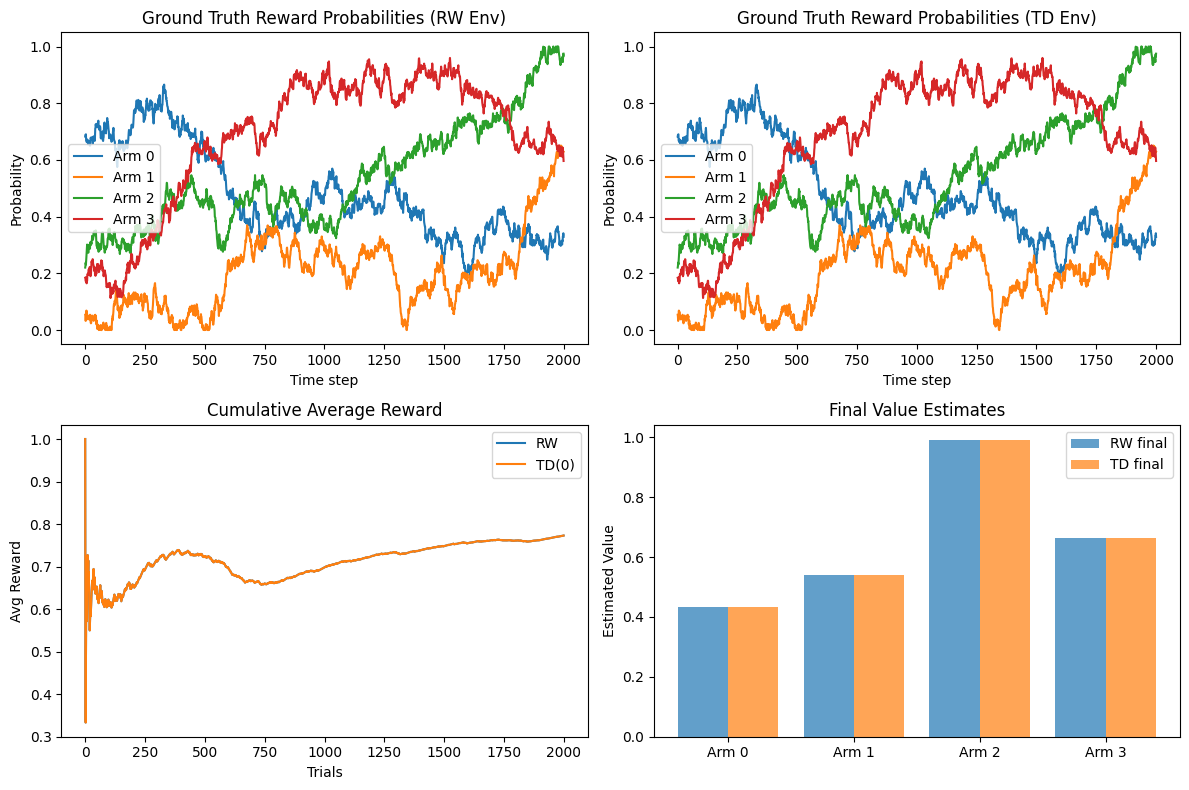

[RW] Mean reward: 0.773
[TD] Mean reward: 0.773
RW final estimates: [0.43403703 0.53968409 0.99189827 0.66428689]
TD final estimates: [0.43403703 0.53968409 0.99189827 0.66428689]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1) Drifting N-Armed Bandit Environment
# ----------------------------------------------------
class DriftingNArmedBandit:
    """
    An N-armed bandit where each arm's reward probability drifts over time
    via a random walk.
    """
    def __init__(self, n_arms=4, drift_scale=0.01, seed=None):
        """
        Args:
            n_arms (int): Number of arms.
            drift_scale (float): Std dev for the Gaussian random walk step.
            seed (int): Optional random seed.
        """
        self.n_arms = n_arms
        self.drift_scale = drift_scale
        self.rng = np.random.default_rng(seed)

        # Initialize each arm's probability randomly in [0,1]
        self.reward_probs = self.rng.random(n_arms)

    def step(self, action):
        """
        1) Sample reward from Bernoulli with probability = reward_probs[action].
        2) Drift each arm's probability for the next step.
        3) Return the reward.
        """
        # 1) Reward sample
        p = self.reward_probs[action]
        reward = 1.0 if self.rng.random() < p else 0.0

        # 2) Random walk update for each arm
        self.reward_probs += self.rng.normal(0, self.drift_scale, size=self.n_arms)
        # Clip to [0,1]
        np.clip(self.reward_probs, 0, 1, out=self.reward_probs)

        return reward


# ----------------------------------------------------
# 2) Rescorla-Wagner Agent
# ----------------------------------------------------
class RescorlaWagnerAgent:
    def __init__(self, n_arms, alpha=0.1, epsilon=0.1, init_value=0.0, seed=None):
        """
        Args:
            n_arms (int): Number of arms.
            alpha (float): Learning rate for RW.
            epsilon (float): Epsilon for epsilon-greedy exploration.
            init_value (float): Initial estimated value.
            seed (int): Random seed.
        """
        self.n_arms = n_arms
        self.alpha = alpha
        self.epsilon = epsilon
        self.V = np.full(n_arms, init_value, dtype=float)
        self.rng = np.random.default_rng(seed)

    def select_action(self):
        """
        Epsilon-greedy policy based on self.V.
        """
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.n_arms)
        else:
            return np.argmax(self.V)

    def update(self, arm, reward):
        """
        V[arm] <- V[arm] + alpha * (reward - V[arm])
        """
        prediction_error = reward - self.V[arm]
        self.V[arm] += self.alpha * prediction_error


# ----------------------------------------------------
# 3) TD(0) Agent (Single-step)
# ----------------------------------------------------
class TDAgent:
    """
    A simple one-step TD agent for a bandit (essentially identical to RW in a single-step).
    """
    def __init__(self, n_arms, alpha=0.1, gamma=1.0, epsilon=0.1, init_value=0.0, seed=None):
        self.n_arms = n_arms
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.full(n_arms, init_value, dtype=float)
        self.rng = np.random.default_rng(seed)

    def select_action(self):
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.n_arms)
        else:
            return np.argmax(self.Q)

    def update(self, arm, reward):
        td_error = reward - self.Q[arm]
        self.Q[arm] += self.alpha * td_error


# ----------------------------------------------------
# 4) Simulation Function
# ----------------------------------------------------
def run_simulation(env, agent, n_steps=1000):
    """
    Run a bandit simulation for n_steps. 
    Also track the environment's reward probabilities over time.

    Returns:
        rewards (ndarray): shape (n_steps,) -> reward per step
        estimates (ndarray): shape (n_steps, n_arms) -> agent's estimates each step
        true_probs (ndarray): shape (n_steps+1, n_arms) -> ground truth reward probs each step
    """
    rewards = np.zeros(n_steps, dtype=float)
    n_arms = env.n_arms

    # We'll store the agent's estimates after each step, plus the env's reward probs
    estimates = np.zeros((n_steps, n_arms))
    
    # true_probs will store environment's probabilities at each step:
    # We'll store the initial probabilities at index 0, then after each step for indices 1..n_steps
    true_probs = np.zeros((n_steps + 1, n_arms))
    true_probs[0, :] = env.reward_probs

    for t in range(n_steps):
        arm = agent.select_action()
        reward = env.step(arm)
        agent.update(arm, reward)

        rewards[t] = reward

        # record agent's current estimates
        if hasattr(agent, 'V'):
            estimates[t, :] = agent.V
        else:
            estimates[t, :] = agent.Q

        # record environment's new probabilities after drift
        true_probs[t + 1, :] = env.reward_probs

    return rewards, estimates, true_probs


# ----------------------------------------------------
# 5) Main Demo/Comparison
# ----------------------------------------------------
if __name__ == "__main__":

    # Number of arms
    n_arms = 4
    # Drifting scale
    drift_scale = 0.01
    # Number of trials
    n_steps = 2000
    # Seed for reproducible drifts
    env_seed = 123

    # 1) Instantiate the environment
    env1 = DriftingNArmedBandit(n_arms=n_arms, drift_scale=drift_scale, seed=env_seed)

    # 2) Create the Rescorla-Wagner agent
    rw_agent = RescorlaWagnerAgent(n_arms=n_arms, alpha=0.1, epsilon=0.1, seed=42)

    # 3) Run simulation with the RW agent
    rw_rewards, rw_estimates, rw_probs = run_simulation(env1, rw_agent, n_steps)

    # 4) TD(0) agent, run on a separate environment (same drift path)
    env2 = DriftingNArmedBandit(n_arms=n_arms, drift_scale=drift_scale, seed=env_seed)
    td_agent = TDAgent(n_arms=n_arms, alpha=0.1, gamma=1.0, epsilon=0.1, seed=42)
    td_rewards, td_estimates, td_probs = run_simulation(env2, td_agent, n_steps)

    # Compute cumulative average reward
    rw_cumavg = np.cumsum(rw_rewards) / (np.arange(n_steps) + 1)
    td_cumavg = np.cumsum(td_rewards) / (np.arange(n_steps) + 1)

    # --------------- PLOTTING ---------------

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    # (1) Plot the environment's drift over time (for the RW environment)
    #     We'll show all arms
    for arm_i in range(n_arms):
        axes[0].plot(rw_probs[:, arm_i], label=f"Arm {arm_i}")
    axes[0].set_title("Ground Truth Reward Probabilities (RW Env)")
    axes[0].set_xlabel("Time step")
    axes[0].set_ylabel("Probability")
    axes[0].legend()

    # (2) Plot the environment's drift over time (for the TD environment)
    #     We'll show all arms
    for arm_i in range(n_arms):
        axes[1].plot(td_probs[:, arm_i], label=f"Arm {arm_i}")
    axes[1].set_title("Ground Truth Reward Probabilities (TD Env)")
    axes[1].set_xlabel("Time step")
    axes[1].set_ylabel("Probability")
    axes[1].legend()

    # (3) Plot the running average reward
    axes[2].plot(rw_cumavg, label="RW")
    axes[2].plot(td_cumavg, label="TD(0)")
    axes[2].set_title("Cumulative Average Reward")
    axes[2].set_xlabel("Trials")
    axes[2].set_ylabel("Avg Reward")
    axes[2].legend()

    # (4) Bar chart of final estimates
    # We'll read out the final estimate arrays from the agents
    # (We've got them in memory: rw_agent.V or rw_agent.Q, etc.)
    if hasattr(rw_agent, 'V'):
        rw_final = rw_agent.V
    else:
        rw_final = rw_agent.Q

    if hasattr(td_agent, 'Q'):
        td_final = td_agent.Q
    else:
        td_final = td_agent.V

    x = np.arange(n_arms)
    bar_width = 0.4
    axes[3].bar(x - 0.2, rw_final, width=bar_width, alpha=0.7, label="RW final")
    axes[3].bar(x + 0.2, td_final, width=bar_width, alpha=0.7, label="TD final")
    axes[3].set_xticks(x)
    axes[3].set_xticklabels([f"Arm {i}" for i in range(n_arms)])
    axes[3].set_ylabel("Estimated Value")
    axes[3].set_title("Final Value Estimates")
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    # Print final performance
    print(f"[RW] Mean reward: {rw_rewards.mean():.3f}")
    print(f"[TD] Mean reward: {td_rewards.mean():.3f}")

    if hasattr(rw_agent, 'V'):
        print("RW final estimates:", rw_agent.V)
    else:
        print("RW final estimates:", rw_agent.Q)

    if hasattr(td_agent, 'Q'):
        print("TD final estimates:", td_agent.Q)
    else:
        print("TD final estimates:", td_agent.V)
